<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/StandingTime_MonthsInMilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for standing time MonthsInMilk

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

## Data loading into dataframe

In [ ]:
%%R
url = ('/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=StandingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-35.c000.csv')

dataset = read.csv(url)



In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=StandingTimeMinutesPer2Hours/part-00000-tid-5876581890551720600-0e9afc0a-339b-4a8d-9159-2f92fdf60451-17582-34.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned02042021/ObservationType=StandingTimePerDay/part-00000-tid-1349821109549544597-c9251edd-6d65-49bf-bc6f-941ced55eb0c-3065-35.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, -1, 10)) %>%
   dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 8972             2011           2      0            Winter        23   
2 8971             2011           2      4            Autumn        23   
3 8977             2011           2      3            Spring        22   
4 121              2746           1      1            Summer        22   
5 111              2746           3+     6            Summer        23   
6 9017             2011           2      0            Autumn        22   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [54,056 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1051 levels "1","2","3","4",..: 908 907 913 121 111 929 115 925 135 936 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 1 1 1 4 4 1 4 1 4 1 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 2 2 2 1 3 2 3 1 3 2 ...
 $ MonthsInMilk    : Factor w/ 12 levels "-1","0","1","2",..: 2 6 5 3 8 2 6 6 4 3 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 1 2 3 3 1 2 1 4 1 ...
 $ Hour            : Factor w/ 2 levels "22","23": 2 2 1 1 2 1 1 2 1 2 ...
 $ SensorValue     : num [1:54056] 704 469 643 608 705 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 2 2 2 2 2 2 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  736
2 2                  712
3 3+                 742


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1051


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )



## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 681234 681261 -340614   681228                         
Model1.0   14 676000 676125 -337986   675972 5255.4 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 681234 681261 -340614   681228                         
Model1.1    5 681162 681207 -340576   681152 75.714  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 681234 681261 -340614   681228                         
Model1.2    6 681167 681220 -340578   681155 72.824  3   1.06e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 681234 681261 -340614   681228                         
Model1.3    4 681197 681232 -340594   681189 39.262  1  3.706e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
    (1 | HerdIdentifier:AnimalIdentifier)
              npar    AIC    LRT   Pr(Chi)    
<none>             675749                     
Parity           2 675899  153.6 < 2.2e-16 ***
MonthsInMilk    11 681048 5320.6 < 2.2e-16 ***
CalvingSeason    3 675832   88.9 < 2.2e-16 ***
MilkingType      1 675783   35.9 2.117e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + CalvingSeason + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + CalvingSeason + MilkingType + 
Model2.1:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 675749 675927 -337855   675709                         
Model2.1   42 675432 675806 -337674   675348 361.23 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + CalvingSeason + Parity +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + CalvingSeason + Parity + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 675749 675927 -337855   675709                         
Model2.2   31 675668 675944 -337803   675606 103.01 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + MilkingType + 
Model2.3:     (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 675749 675927 -337855   675709                         
Model2.3   53 675343 675815 -337619   675237 472.05 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + MilkingType + 
Model2.0:     (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
Model2.4:     MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   20 675749 675927 -337855   675709                         
Model2.4   86 674930 675695 -337379   674758 951.18 66  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
summary(Model2.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity +  
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
   Data: AnalysisData

      AIC       BIC    logLik  deviance  df.resid 
 674930.0  675695.2 -337379.0  674758.0     53970 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-11.683  -0.407   0.010   0.444  55.606 

Random effects:
 Groups                          Name        Variance Std.Dev.
 HerdIdentifier:AnimalIdentifier (Intercept)  5839     76.41  
 Residual                                    14286    119.52  
Number of obs: 54056, groups:  HerdIdentifier:AnimalIdentifier, 1689

Fixed effects:
                                    Estimate Std. Error t value
(Intercept)                        632.97512    7.31111  86.577
MonthsInMilk0                       24.80145    8.23090   3.013
MonthsInMilk1                      115.45901    8.47767  13.619
MonthsInMilk2    

R[write to console]: 
Correlation matrix not shown by default, as p = 84 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R
finalModel <- Model2.4
Modeldrop <- drop1(finalModel, test="Chisq")
if("Pr(>F)" %in% colnames(Modeldrop))
{
  Pvalues <- Modeldrop$`Pr(>F)`
} else 
{
  Pvalues <- Modeldrop$`Pr(Chi)`
}
Modeldrop

Single term deletions

Model:
SensorValue ~ MonthsInMilk * CalvingSeason + MonthsInMilk * Parity + 
    MonthsInMilk * MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
                           npar    AIC    LRT   Pr(Chi)    
<none>                          674930                     
MonthsInMilk:CalvingSeason   33 675354 489.55 < 2.2e-16 ***
MonthsInMilk:Parity          22 675270 384.00 < 2.2e-16 ***
MonthsInMilk:MilkingType     11 674998  89.83 1.798e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodelStandingtime.rdata")

# Final model analysis of variance

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                              Chisq Df Pr(>Chisq)    
MonthsInMilk               5703.368 11  < 2.2e-16 ***
CalvingSeason                88.888  3  < 2.2e-16 ***
Parity                      147.845  2  < 2.2e-16 ***
MilkingType                  32.758  1  1.044e-08 ***
MonthsInMilk:CalvingSeason  491.834 33  < 2.2e-16 ***
MonthsInMilk:Parity         385.390 22  < 2.2e-16 ***
MonthsInMilk:MilkingType     89.911 11  1.735e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1              628 3.06 Inf       619       637  a      
 0               633 2.83 Inf       625       641  a      
 10              680 2.90 Inf       671       688   b     
 9               685 2.91 Inf       677       694   bc    
 8               688 2.92 Inf       680       696   bc    
 7               689 2.92 Inf       681       697   bc    
 6               693 2.92 Inf       685       702    cd   
 5               701 2.93 Inf       693       710     d   
 4               714 2.92 Inf       706       723      e  
 3               730 2.92 Inf       722       739       f 
 2               745 2.91 Inf       736       753        g
 1               752 2.94 Inf       743       760        g

Results are averaged over the levels of: CalvingSeason, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method 

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 1         686 2.37 Inf       680       692  a    
 2         693 2.34 Inf       687       698   b   
 3+        706 2.26 Inf       701       711    c  

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Summer           684 2.46 Inf       678       690  a    
 Autumn           692 2.46 Inf       686       698   b   
 Spring           698 2.55 Inf       691       704    c  
 Winter           706 2.58 Inf       699       712     d 

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MilkingType), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MilkingType lsmean   SE  df asymp.LCL asymp.UCL .group
 AMS            683 3.54 Inf       675       691  a    
 CMS            707 2.37 Inf       702       712   b   

Results are averaged over the levels of: MonthsInMilk, CalvingSeason, Parity 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 2 estimates 
significance level used: alpha = 0.05 


## Interactions

### MonthsInMilk by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1              618 5.16 Inf       603       633  a      
 0               653 4.26 Inf       641       665   b     
 10              675 4.08 Inf       663       686    c    
 7               676 4.21 Inf       664       688    cd   
 6               676 4.23 Inf       664       689    cd   
 9               678 4.15 Inf       666       690    cd   
 8               679 4.19 Inf       667       691    cd   
 5               682 4.25 Inf       670       695    cd   
 4               691 4.29 Inf       679       704     de  
 3               705 4.32 Inf       693       718      e  
 2               724 4.35 Inf       712       736       f 
 1               774 4.47 Inf       761       787        g

Parity = 2:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 0               622 3.96 Inf       610       633  a      
 -1              632 4.26 Inf       620       644  a      
 10              675 4.28 Inf  

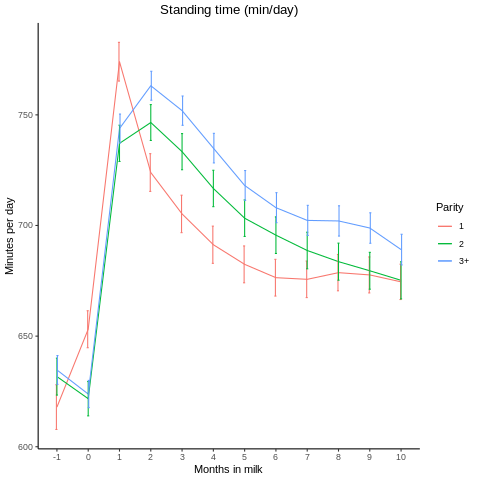

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 0               623 4.65 Inf       610       637  a       
 -1              630 4.89 Inf       616       644  a       
 10              671 4.76 Inf       657       685   b      
 7               676 4.80 Inf       662       690   b      
 9               677 4.78 Inf       663       690   b      
 8               677 4.79 Inf       663       691   b      
 6               678 4.79 Inf       664       692   b      
 5               683 4.79 Inf       669       697   b      
 4               700 4.80 Inf       686       713    c     
 3               716 4.80 Inf       703       730     d    
 2               728 4.80 Inf       714       741     de   
 1               733 4.84 Inf       719       747      e   

MilkingType = CMS:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 -1              626 3.35 Inf       616       636  a       
 0               642 3.06 Inf       634       651   b      
 

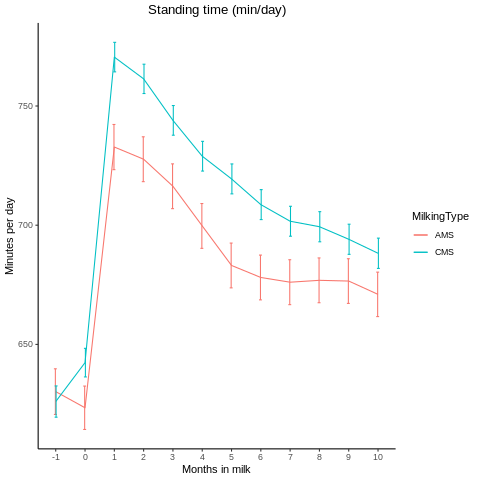

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### MonthsInMilk by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ MonthsInMilk|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 54056' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 54056' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 54056)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1              641 4.46 Inf       628       654  a      
 0               647 3.83 Inf       636       658  a      
 7               682 4.12 Inf       670       694   b     
 8               686 4.51 Inf       673       699   bc    
 6               687 4.15 Inf       675       699   bc    
 5               691 4.10 Inf       679       703   bc    
 9               692 4.49 Inf       679       705   bc    
 10              694 4.43 Inf       681       706   bcd   
 4               699 4.37 Inf       687       712    cd   
 3               710 4.32 Inf       698       723     d   
 2               728 3.94 Inf       716       739      e  
 1               745 4.03 Inf       733       756       f 

CalvingSeason = Spring:
 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group  
 -1              611 4.60 Inf       598       624  a      
 0               625 4.15 Inf       614       637  a      
 10    

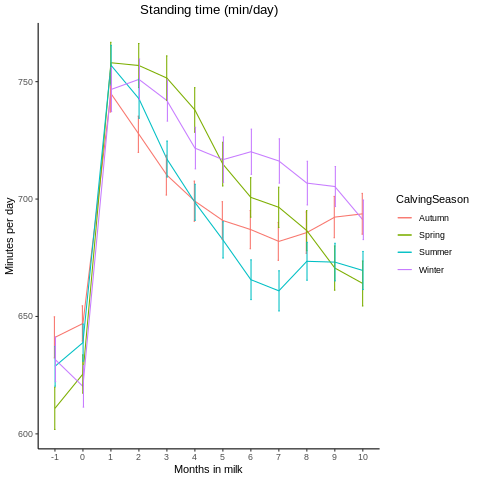

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(MonthsInMilk == max(as.numeric(MonthsInMilk)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=MonthsInMilk,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Standing time (min/day)", 
    y="Minutes per day" , 
    x = "Months in milk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))